# PHDNDF Plotting And Analysis Stage

In [1]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\ode-biomarker-project


In [2]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

## Model Selection of FGFR4 Dynamic Feautres

In [3]:
# load in original ccle data
loading_code = 'generic-gdsc-1-FGFR_0939-LN_IC50-fgfr4_ccle_dynamic_features-true-Row'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
feature_data, label_data = data_link.get_data_using_code(loading_code)

In [4]:
from toolkit import *

powerkit = Powerkit(feature_data, label_data)

rngs = powerkit.generate_rng_list(100)

rngs

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


array([58372, 74949, 87518, 51196, 44896, 82467, 22961, 98711, 12769,
       94620, 35391, 30976, 71626, 76213, 72433, 17405, 38273, 95172,
        1013, 75046, 78353, 72364, 83458, 85511, 40235, 88275, 58642,
       39824, 60317, 79283, 94582, 85281, 92023, 10063, 71970, 84763,
       39567, 39519, 38881, 51277, 19709, 97417, 76131, 18003, 49746,
       15903, 50278, 81046, 39842, 53516, 80008, 97225, 56367, 96643,
       14544, 18694, 30617, 61584, 94403, 57445, 32997, 89065, 74315,
       29084, 92992, 66002, 62087, 19006, 65502, 64714, 26053, 67268,
       26417, 14590, 37950, 89379, 27458, 15515, 90683,   240, 92686,
         156,   911, 56145, 27171, 65618, 74029, 22380, 99519, 74102,
       40211, 26743, 41046, 73820, 79638, 81447, 30402,  3762, 65714,
       94057])

In [22]:
def pipeline_func(X_train, y_train, rng, model_used, **kwargs):
    selected_features, scores = f_regression_select(X_train, y_train, 10)
    model = get_model_from_string(model_used, **kwargs)
    model.fit(X_train, y_train)
    return {'model': model}


def eval_func(X_test, y_test, pipeline_components=None, **kwargs):
    y_pred = pipeline_components['model'].predict(X_test)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': None}

model_used = 'SVR'
powerkit.add_condition(model_used, False, pipeline_func, {'model_used': model_used}, eval_func, {})


In [25]:
df = powerkit.run_selected_condition(model_used, rngs, 1, True)
df.sort_values(by='model_performance', ascending=False, inplace=True)
df.head()

rng condition  model_performance    p_vals
68  47418       SVR           0.382188  0.001415
37  17937       SVR           0.314431  0.009559
14  98945       SVR           0.309047  0.010938
28  62434       SVR           0.298525  0.014136
82  87529       SVR           0.289918  0.017323

In [26]:
model_used_2 = 'RandomForestRegressor'
powerkit.add_condition(model_used_2, False, pipeline_func, {'model_used': model_used_2}, eval_func, {})

In [27]:
df = powerkit.run_selected_condition(model_used, rngs, 1, True)
df.sort_values(by='model_performance', ascending=False, inplace=True)
df.head()

rng              condition  model_performance    p_vals
17   28522  RandomForestRegressor           0.450930  0.000128
109  56622  RandomForestRegressor           0.405398  0.000666
129  82924  RandomForestRegressor           0.395792  0.000916
29   98945  RandomForestRegressor           0.387828  0.001184
111  64580  RandomForestRegressor           0.386531  0.001234

## Feature Selection of the Dynamic Features

In [3]:
# load in original ccle data
loading_code = 'generic-gdsc-1-FGFR_0939-LN_IC50-fgfr4_ccle_dynamic_features-true-Row'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
feature_data, label_data = data_link.get_data_using_code(loading_code)

In [6]:
feature_data.shape

(665, 250)

In [4]:
from toolkit import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [ ]:
 
selected_features, scores = f_regression_select(feature_data, label_data, 10)

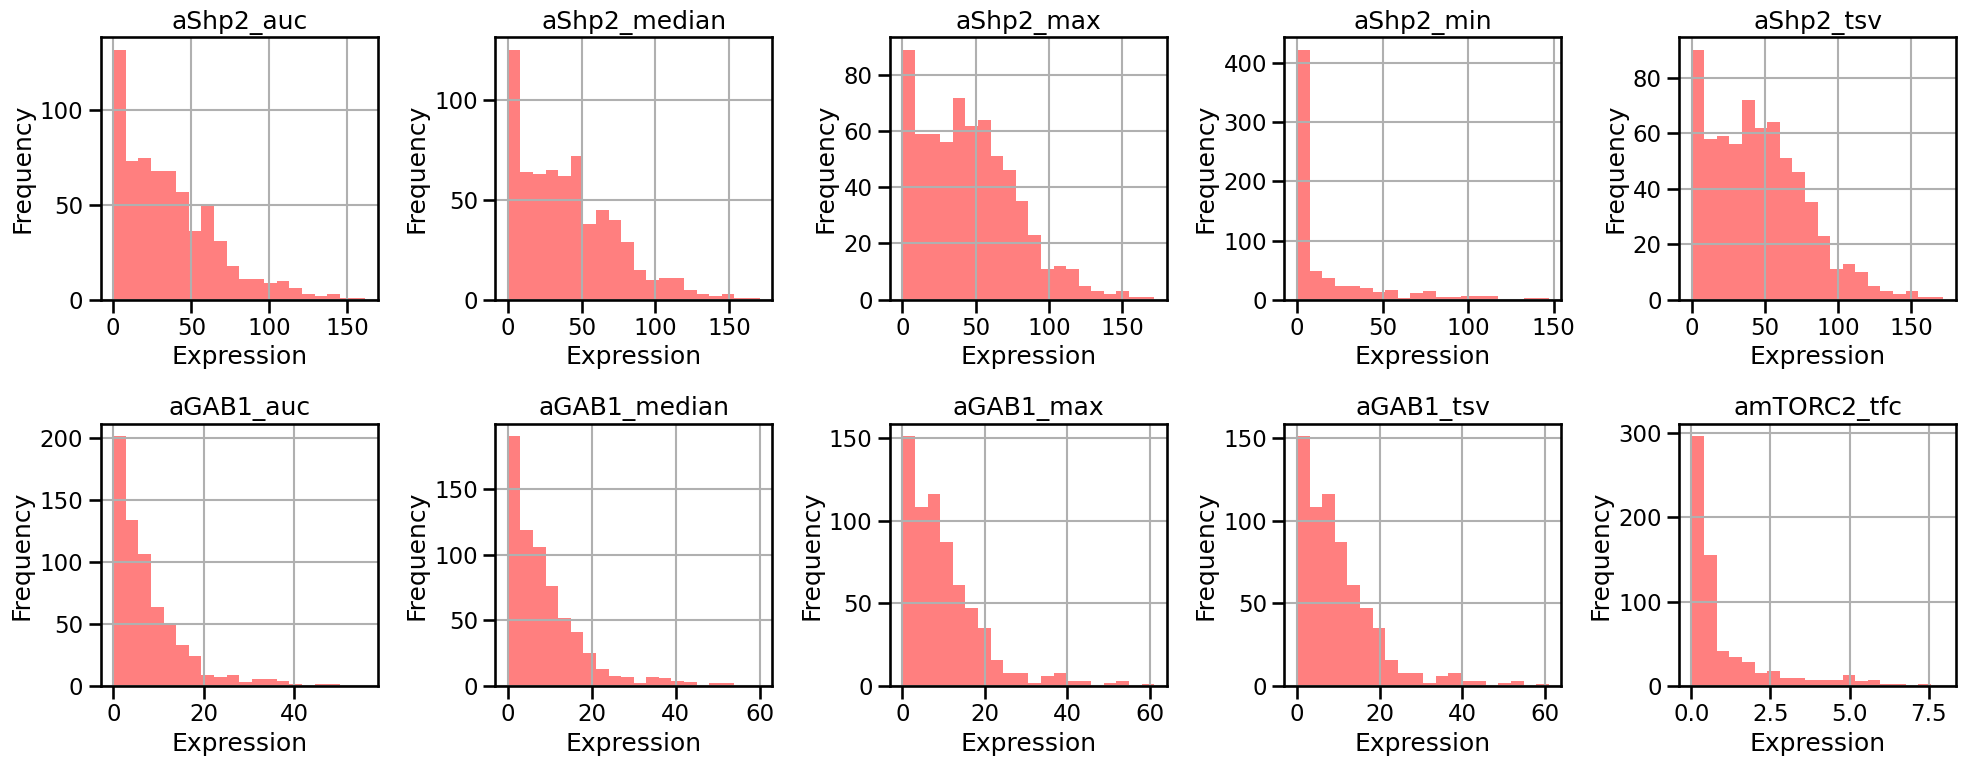

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
# set as talk
sns.set_context('talk')

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i, col in enumerate(selected_features):
    feature_data[col].plot(kind='hist', bins=20, ax=axes[i], color='red', alpha=0.5)
    axes[i].grid()
    axes[i].set_title(col)
    axes[i].set_xlabel('Expression')
plt.tight_layout()

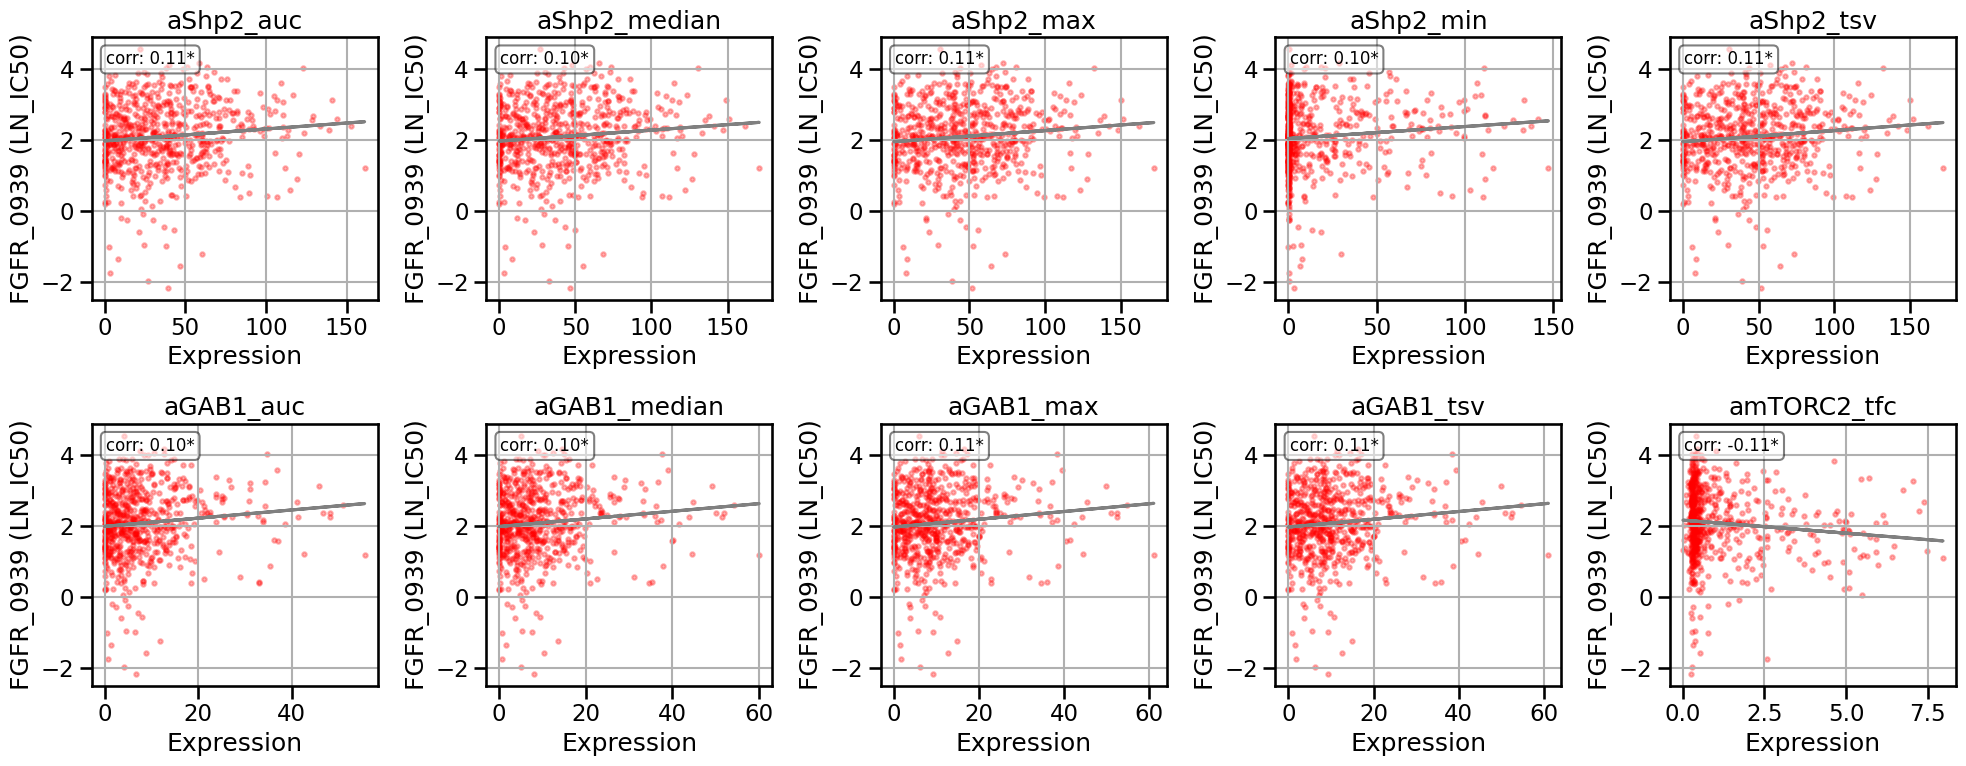

In [12]:
import Visualisation as viz
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

# ignore ConstantInputWarning
import warnings
from scipy.stats import ConstantInputWarning
warnings.simplefilter('ignore', ConstantInputWarning)

# set as talk
sns.set_context('talk')

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i, col in enumerate(selected_features):
    # plot correlation
    X = feature_data[col]
    Y = label_data
    axes[i].scatter(X, Y, color='red', alpha=0.3, s=10)
    m, b = np.polyfit(X, Y, 1)
    axes[i].plot(X, m*X + b, color='grey')
    corr, p_val = pearsonr(label_data, feature_data[col])
    corr_str = f'{corr:.2f}' if p_val > 0.05 else f'{corr:.2f}*'
    axes[i].text(0.05, 0.95, f'corr: {corr_str}', transform=axes[i].transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    # insert annotations
    axes[i].grid()
    # axes[i].text(3, 4.5, f'r={corr}', fontsize=12, verticalalignment='top')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Expression')
    axes[i].set_ylabel('FGFR_0939 (LN_IC50)')

plt.tight_layout()
plt.show()

In [8]:
# print features and scores

for i, col in enumerate(selected_features):
    print(f'{col}: {scores[i]}')

aShp2_auc: 7.4822963587167335
aShp2_median: 7.315179901293522
aShp2_max: 7.496536227327064
aShp2_min: 6.7623133839821525
aShp2_tsv: 7.493012190518677
aGAB1_auc: 7.207746242246933
aGAB1_median: 7.277814184528963
aGAB1_max: 7.572398703529925
aGAB1_tsv: 7.566082339772129
amTORC2_tfc: 8.205615286336183


### Selecting based on pearson correlation coefficient and p-value

In [9]:
features, corr, p_values = pearson_corr_select(feature_data, label_data, feature_data.shape[0], **{'return_all': True})

An input array is constant; the correlation coefficient is not defined.


In [11]:
# make a dataframe 

df = pd.DataFrame({'feature': features, 'corr': corr, 'p_val': p_values})

df.head()

feature      corr     p_val
0  pIGFR_tmin       NaN       NaN
1  pERBB_tmax       NaN       NaN
2  pERBB_tmin       NaN       NaN
3   aShp2_tsv  0.105714  0.006360
4   aShp2_auc  0.105639  0.006397

In [12]:
# get features where absolute value of corr > 0.1 and p_val < 0.05

df = df[(df['corr'] > 0.1) & (df['p_val'] < 0.05)]

df.shape  

(9, 3)

In [13]:
df.head(9)

feature      corr     p_val
3       aShp2_tsv  0.105714  0.006360
4       aShp2_auc  0.105639  0.006397
5    aShp2_median  0.104466  0.007013
129     aGAB1_max  0.106266  0.006089
130     aGAB1_tsv  0.106222  0.006110
131     aShp2_max  0.105738  0.006348
132  aGAB1_median  0.104201  0.007159
133     aGAB1_auc  0.103704  0.007440
134     aShp2_min  0.100482  0.009518

### Selecting based on threshold cut-off

In [10]:
# e.g. F-value >= 2.5 

from toolkit import *
selected_features, scores = f_regression_select(feature_data, label_data, "all")

features_score_dict = dict(zip(selected_features, scores))
# select features with F-value >= 2.5 using dictionary comprehension

threshold_selected_features = {k: v for k, v in features_score_dict.items() if v >= 2.5}





invalid value encountered in sqrt


In [11]:
len(threshold_selected_features)

70

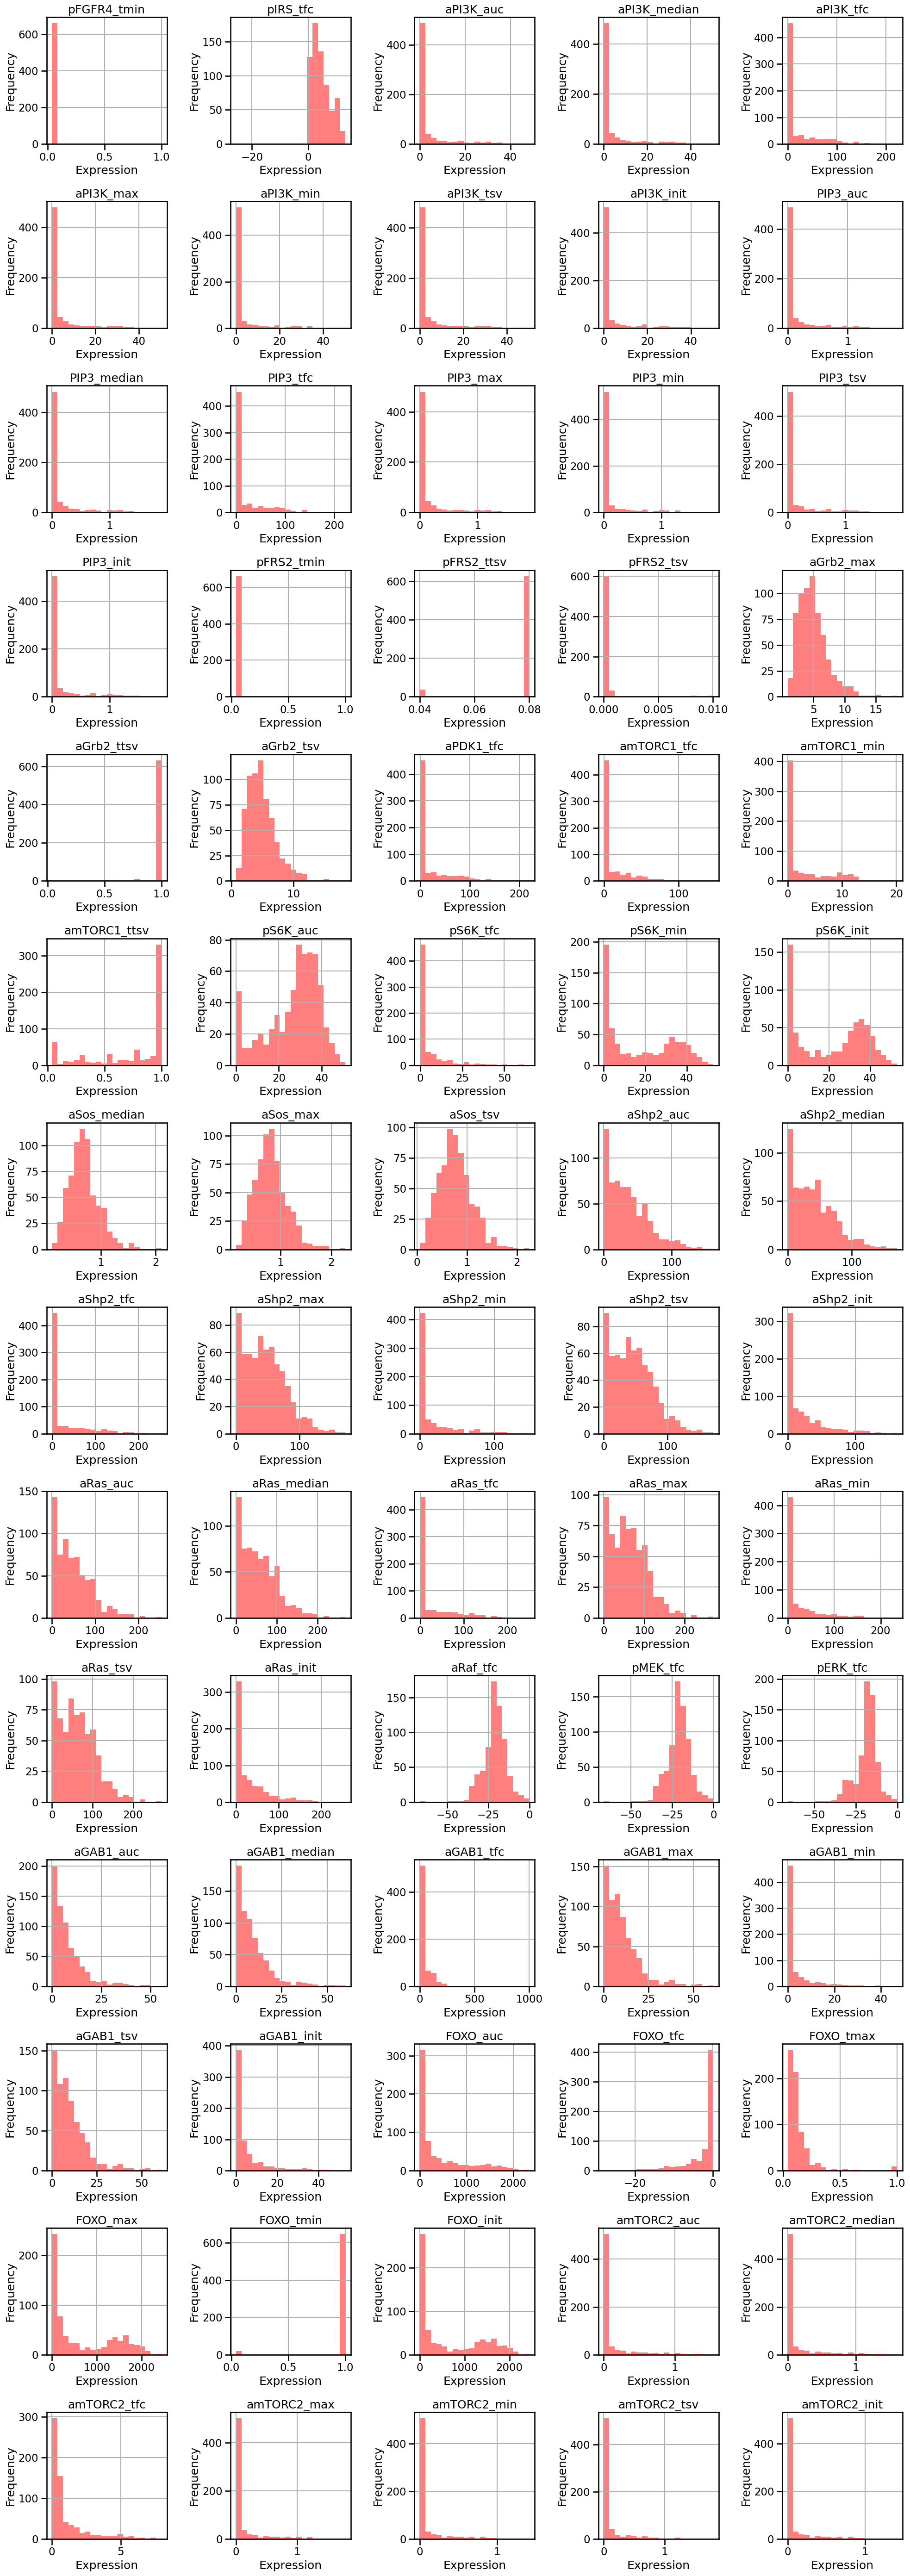

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
# set as talk
sns.set_context('talk')

n = len(threshold_selected_features)

fig, axes = plt.subplots(int(n/5), 5, figsize=(20, 4*int(n/5)))
axes = axes.flatten()
for i, col in enumerate(threshold_selected_features.keys()):
    feature_data[col].plot(kind='hist', bins=20, ax=axes[i], color='red', alpha=0.5)
    axes[i].grid()
    axes[i].set_title(col)
    axes[i].set_xlabel('Expression')
plt.tight_layout()

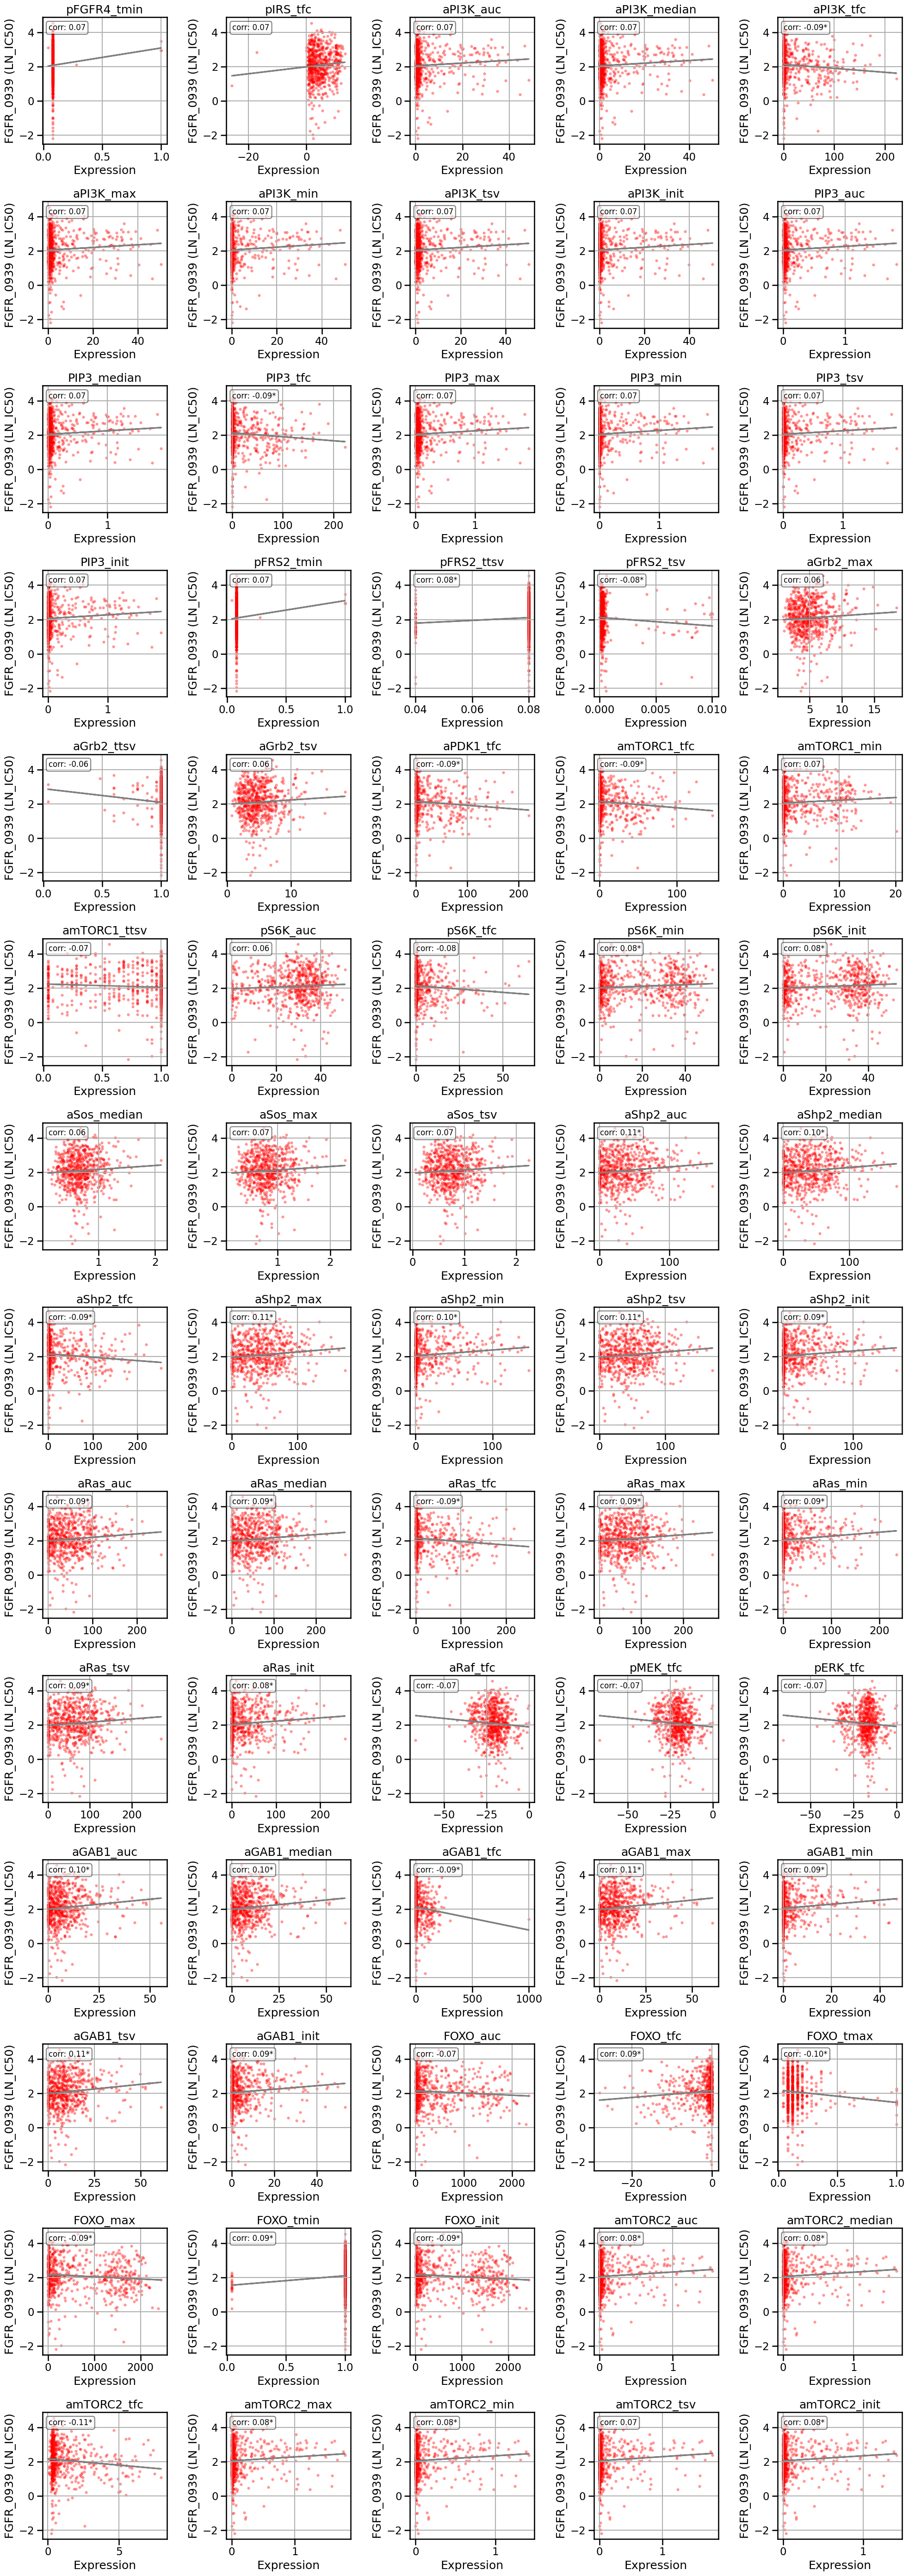

In [17]:
import Visualisation as viz
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

# ignore ConstantInputWarning
import warnings
from scipy.stats import ConstantInputWarning
warnings.simplefilter('ignore', ConstantInputWarning)

# set as talk
sns.set_context('talk')
n = len(threshold_selected_features)
fig, axes = plt.subplots(int(n/5), 5, figsize=(20, 4*int(n/5)))
axes = axes.flatten()
for i, col in enumerate(threshold_selected_features.keys()):
    # plot correlation
    X = feature_data[col]
    Y = label_data
    axes[i].scatter(X, Y, color='red', alpha=0.3, s=10)
    m, b = np.polyfit(X, Y, 1)
    axes[i].plot(X, m*X + b, color='grey')
    corr, p_val = pearsonr(label_data, feature_data[col])
    corr_str = f'{corr:.2f}' if p_val > 0.05 else f'{corr:.2f}*'
    axes[i].text(0.05, 0.95, f'corr: {corr_str}', transform=axes[i].transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    # insert annotations
    axes[i].grid()
    # axes[i].text(3, 4.5, f'r={corr}', fontsize=12, verticalalignment='top')
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Expression')
    axes[i].set_ylabel('FGFR_0939 (LN_IC50)')

plt.tight_layout()
plt.show()

## Bring in FGFR4 Model Individualised Initial Conditions

In [3]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [5]:
import pandas as pd 

initial_conditions = pd.read_csv(f'{path_loader.get_data_path()}data/results/fgfr4_model_initial_conditions/initial_conditions.csv')

In [6]:
# INPUT Data code for match rules table (csv file)
INPUT_DATA_CODE_MATCH_RULES = 'fgfr4_model_ccle_match_rules'
data_link.load_data_code(INPUT_DATA_CODE_MATCH_RULES, verbose=True)
match_rules_df = data_link.data_code_database[INPUT_DATA_CODE_MATCH_RULES]

Data code fgfr4_model_ccle_match_rules loaded at data/ode-models/FGFR4_Model_SY/fgfr4_model_ccle_reference.csv with index position 0. Enforced raw loading: True


In [23]:
match_rules_df.loc[match_rules_df['specie'] == 'IGFR']['initial_value'][0]

7.58

In [36]:
for col in initial_conditions.columns[1:]:
    print(match_rules_df.loc[match_rules_df['specie'] == col]['initial_value'].values[0])

7.58
0.0
962.77
0.0
680.21
0.0
13.04
0.0
2.72
0.0
5000.0
0.0
20.54
0.0
6436.64
0.0
653.74
0.0
39.24
0.0
13.17
0.0
41.1
0.0
3.7
0.0
270.39
0.0
1813.21
0.0
27.49
0.0
1997.8
0.0
2054.4
0.0
20.03
0.0
4.26
0.0
0.0
0.0
0.0
0.0
0.0
5.43
0.0
1025.0
1025.0
13.17
0.0


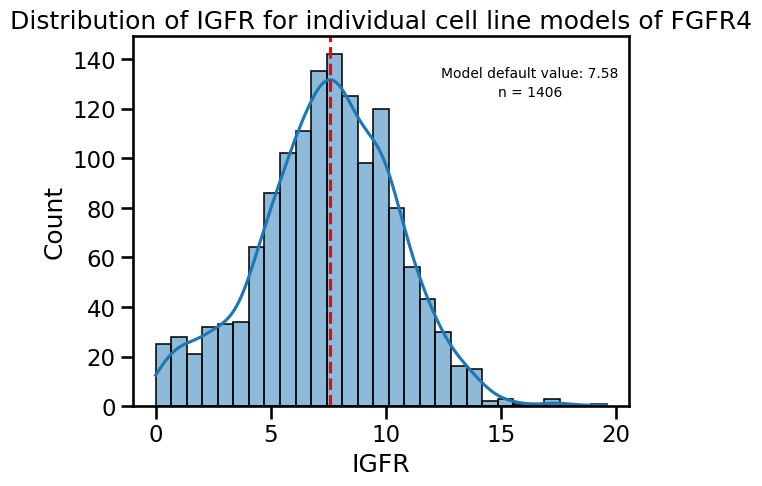

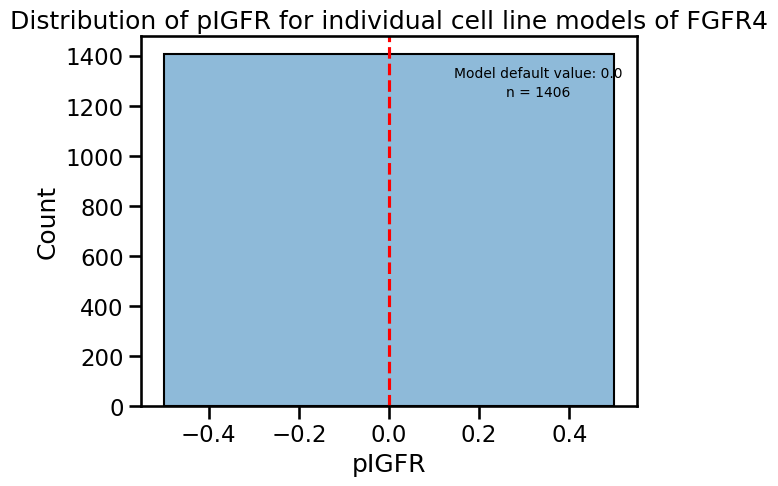

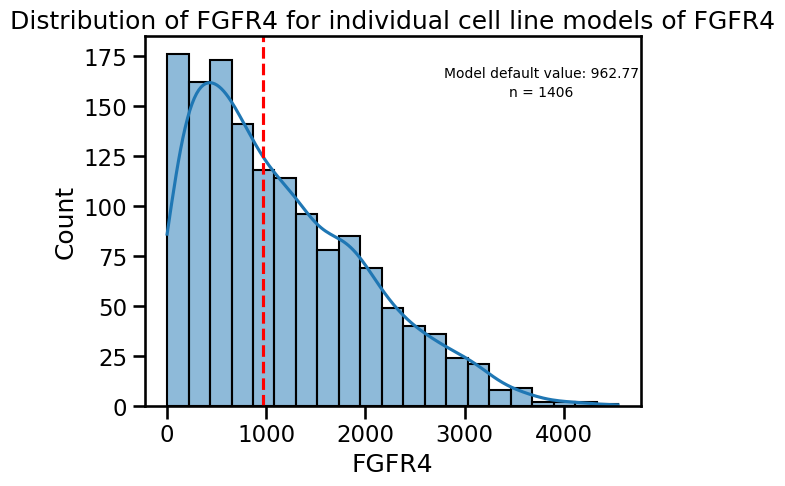

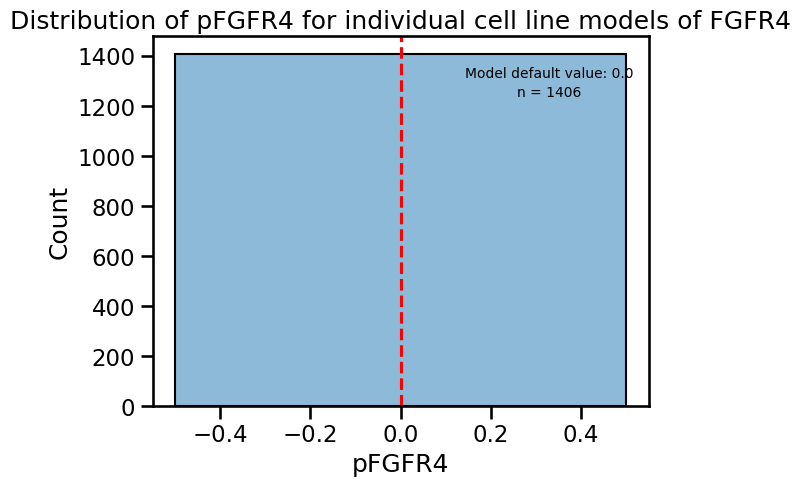

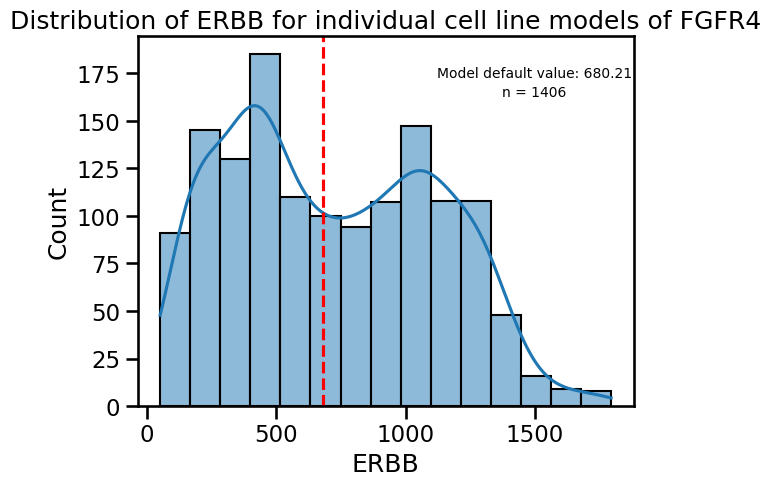

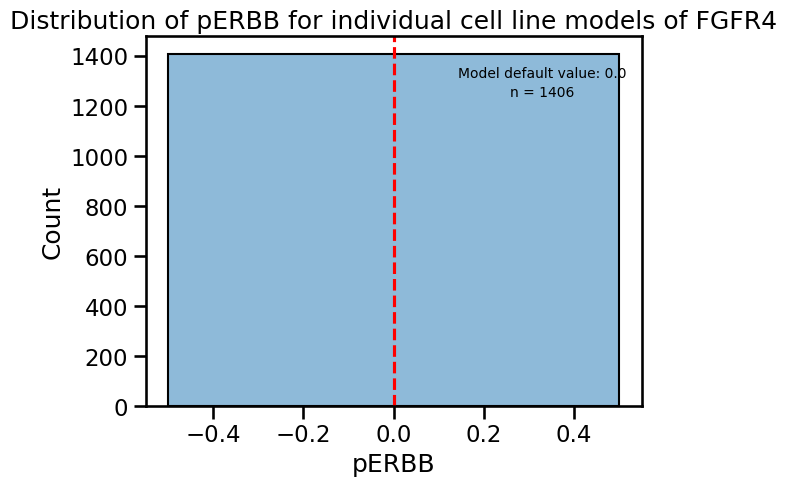

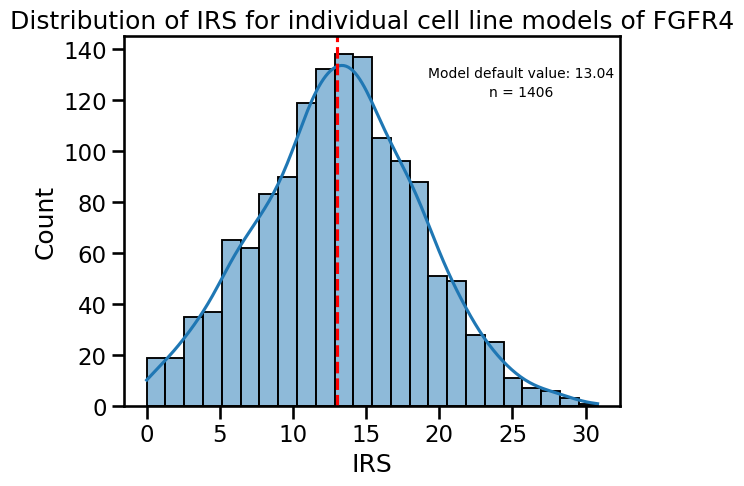

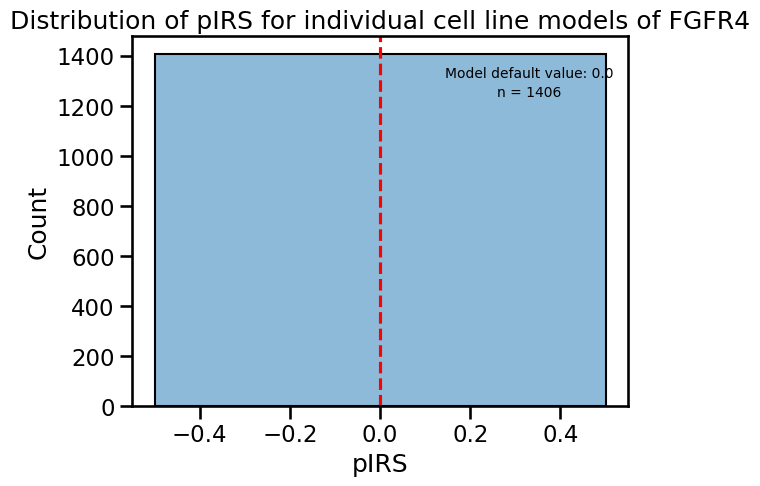

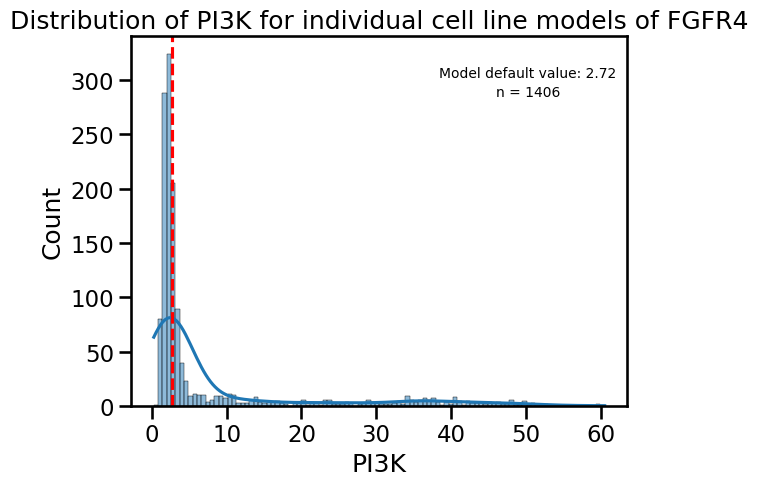

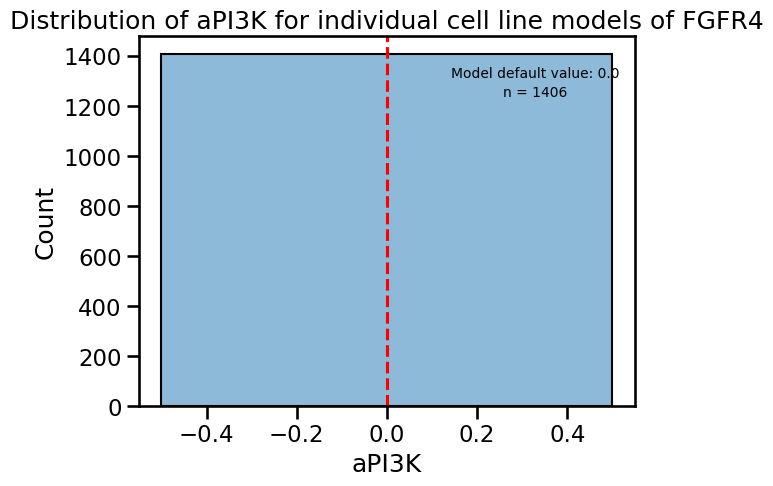

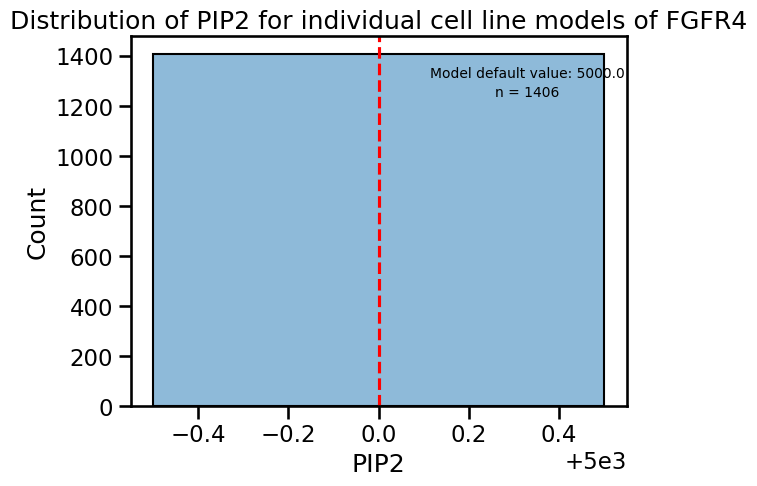

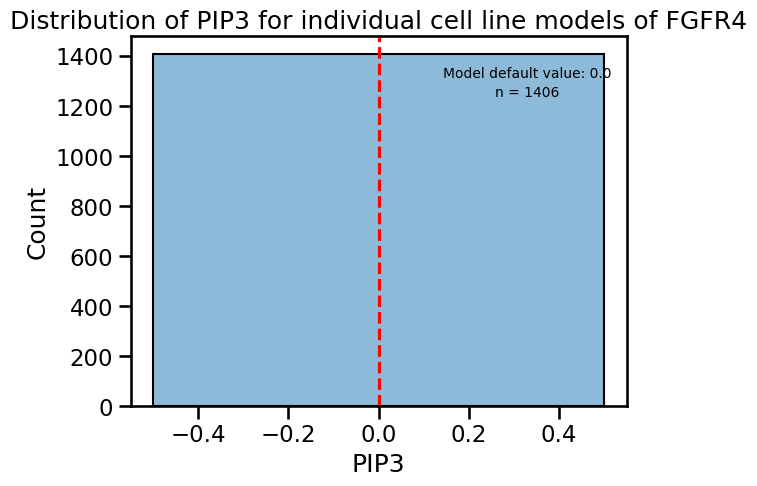

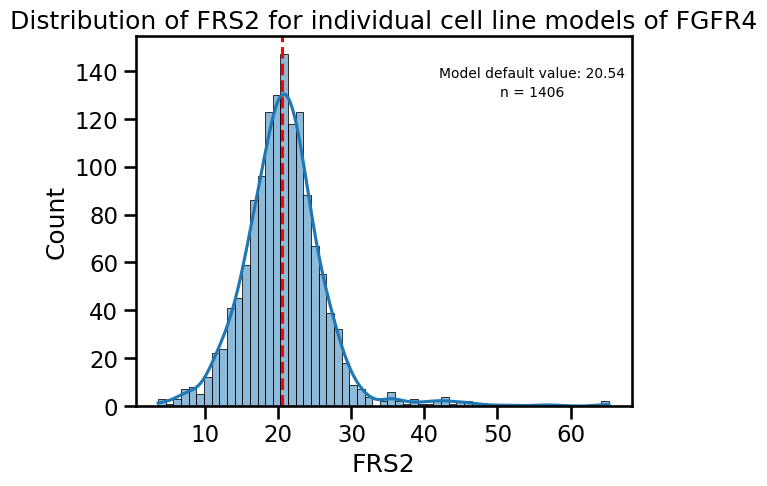

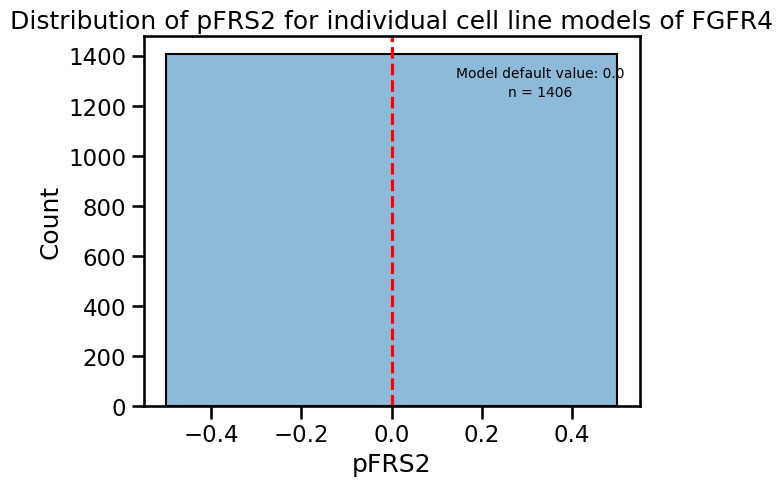

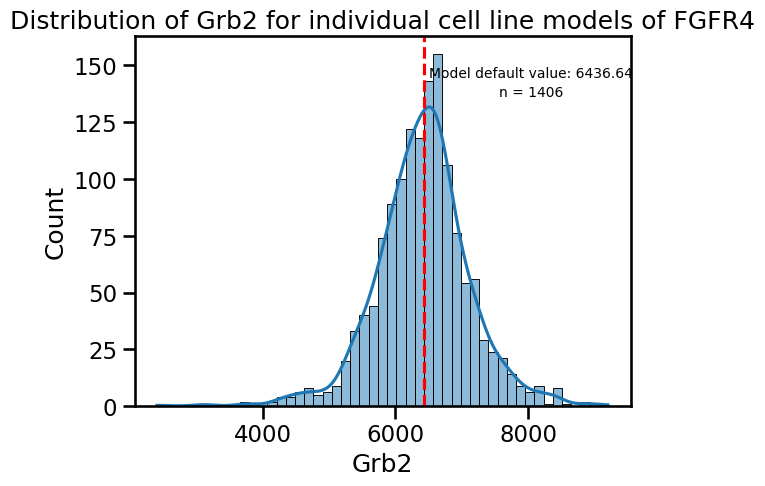

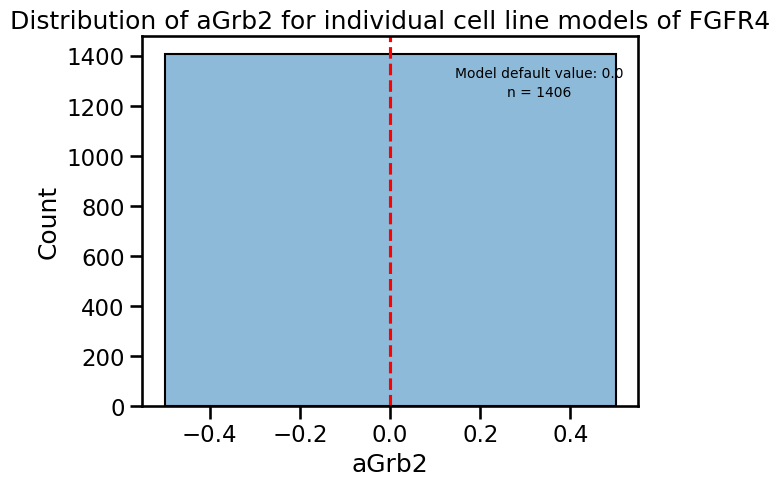

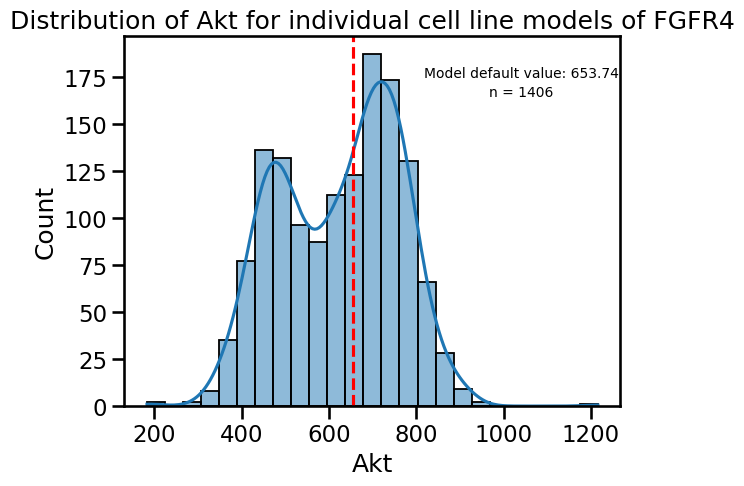

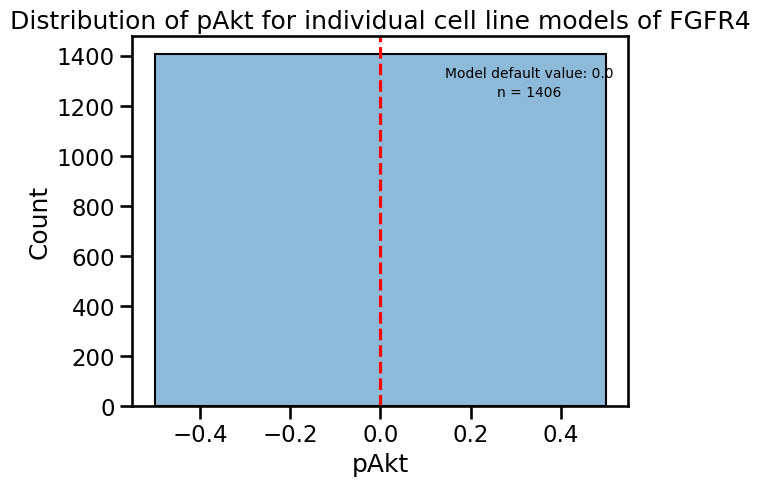

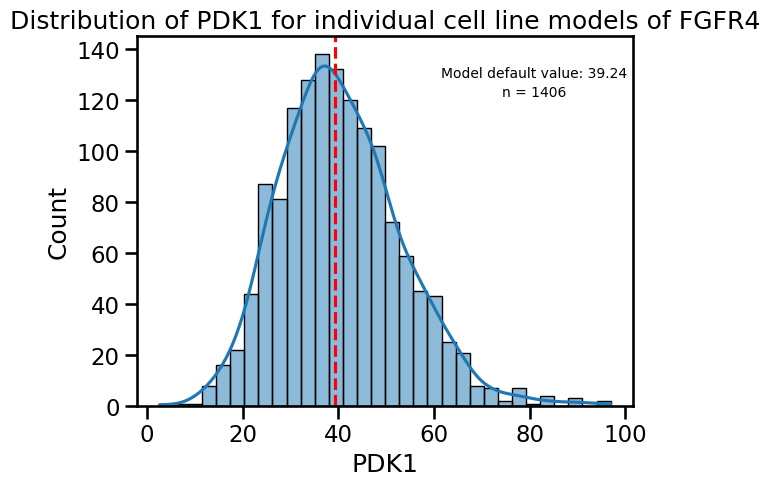

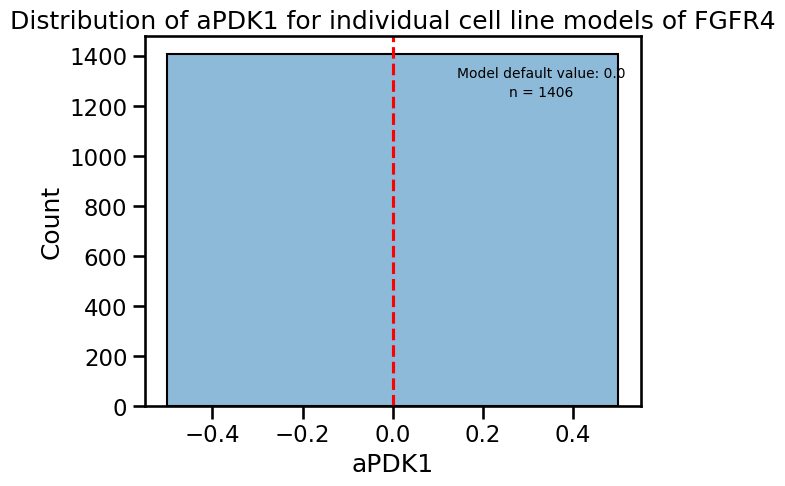

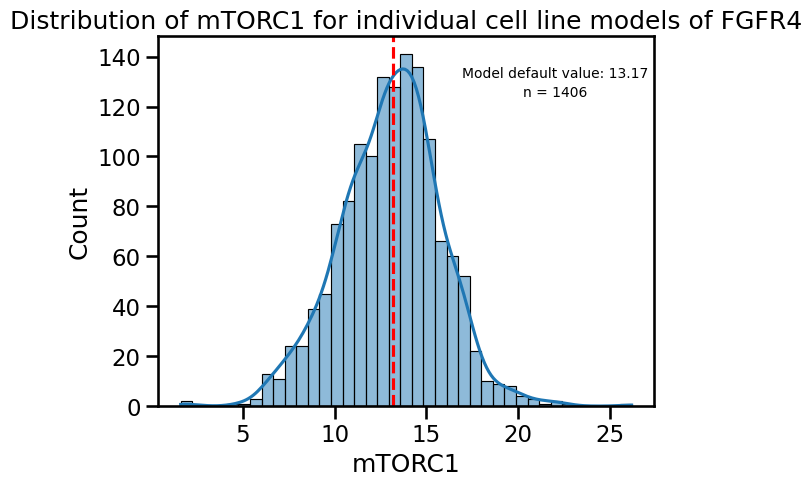

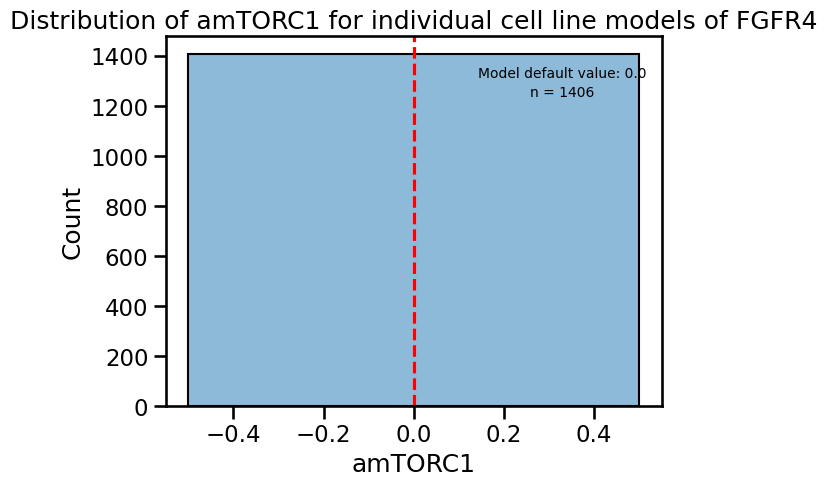

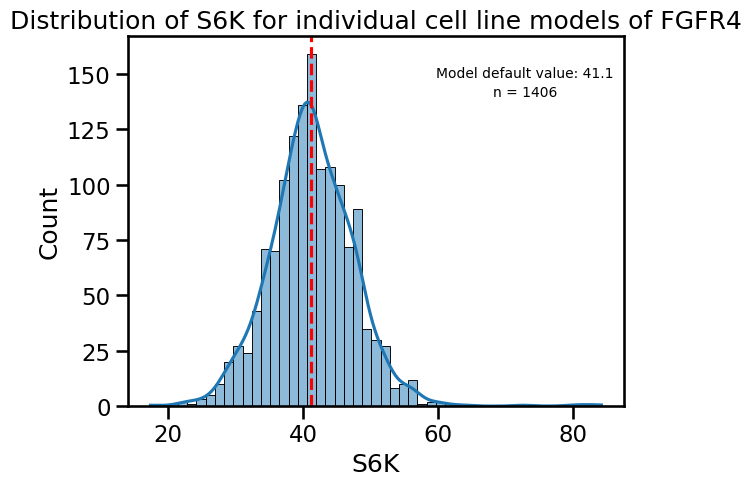

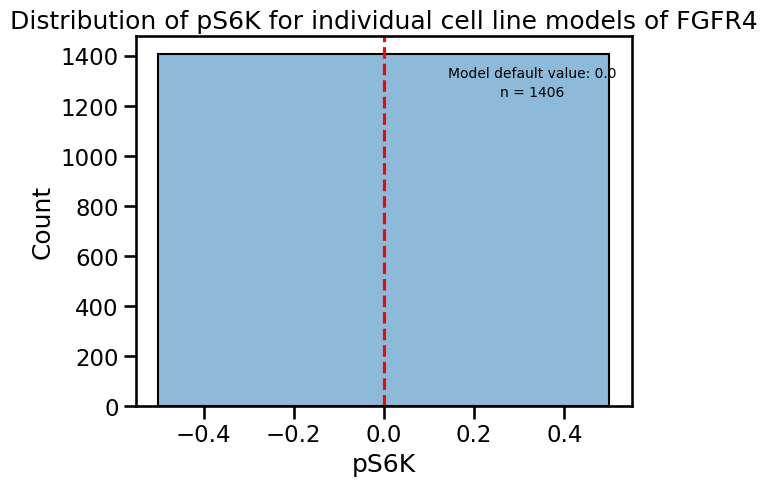

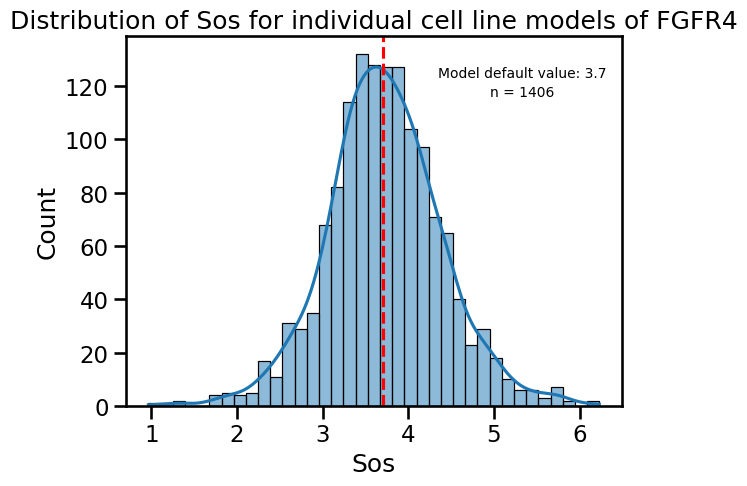

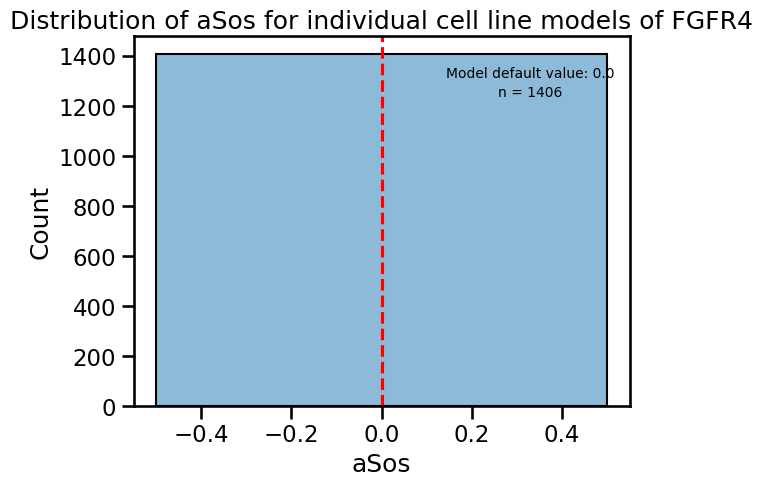

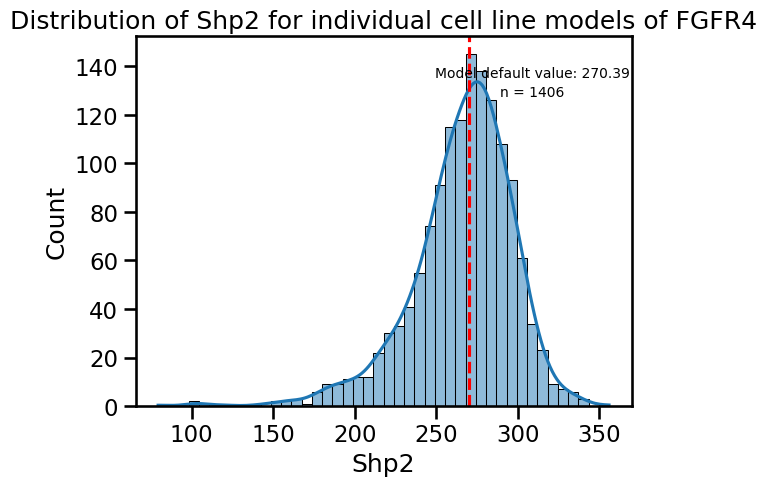

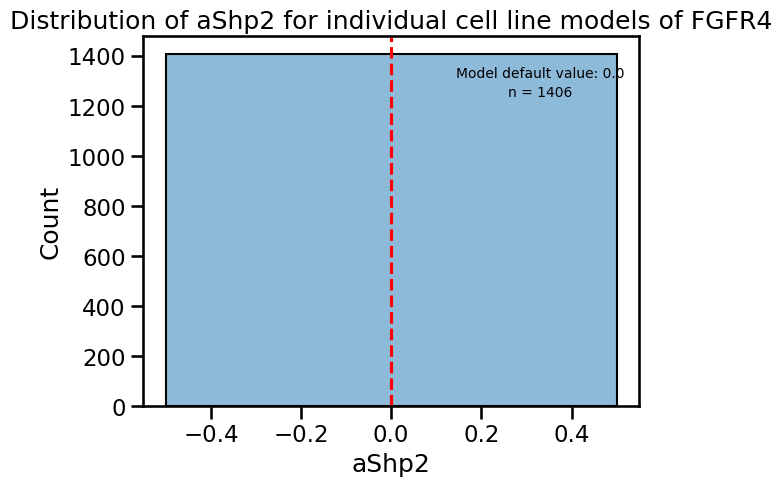

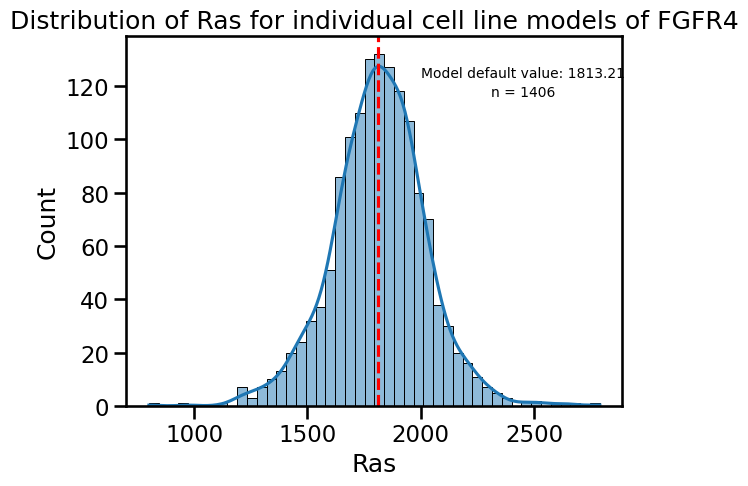

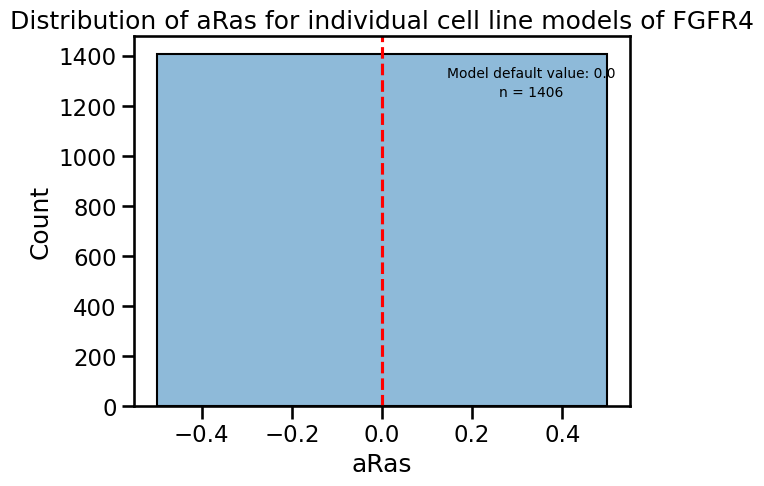

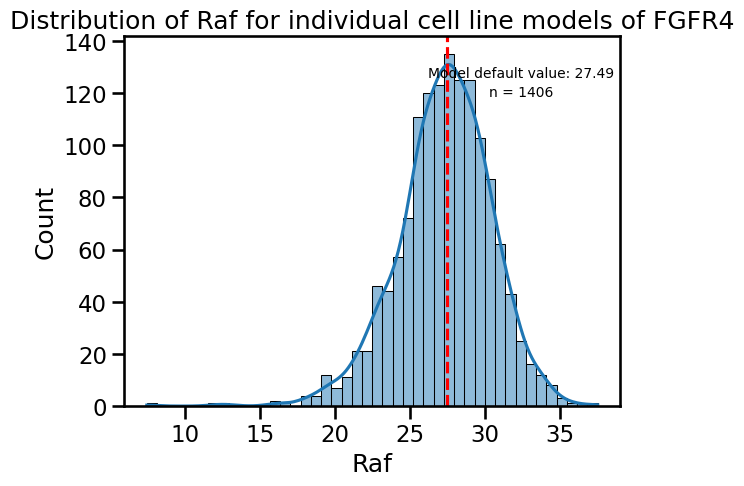

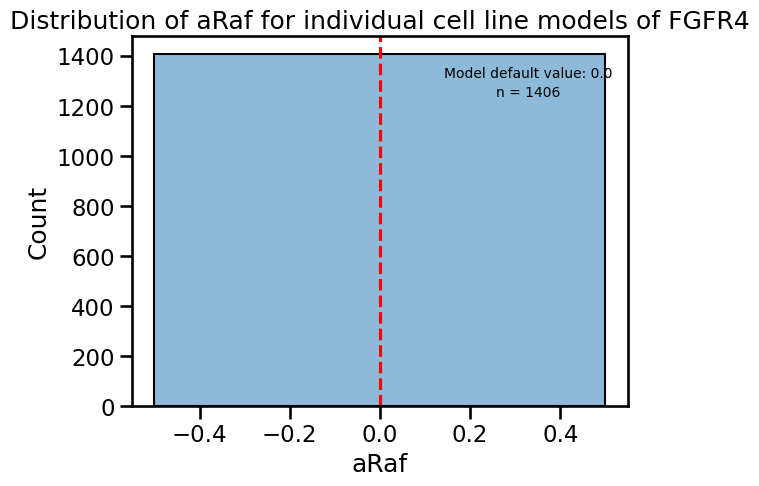

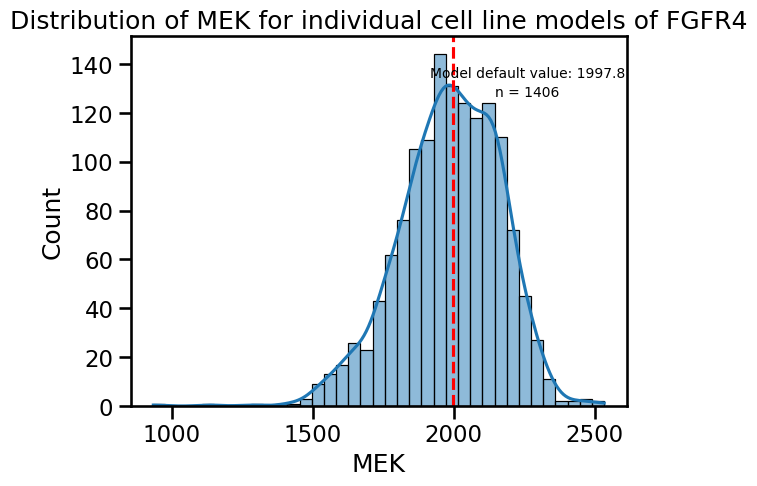

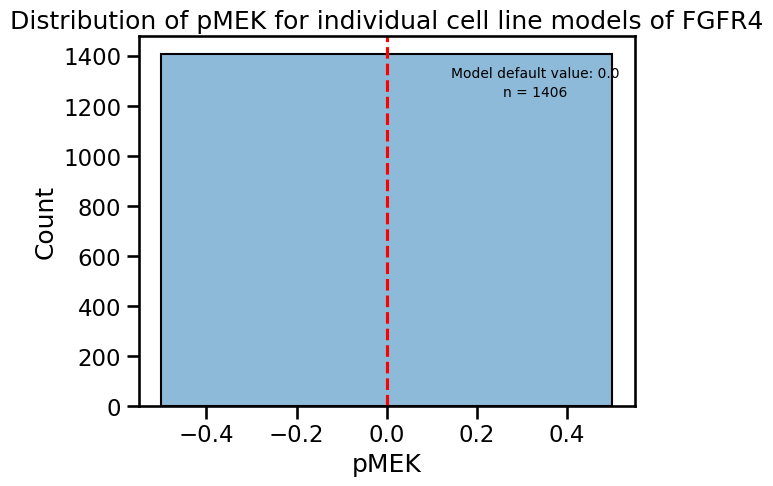

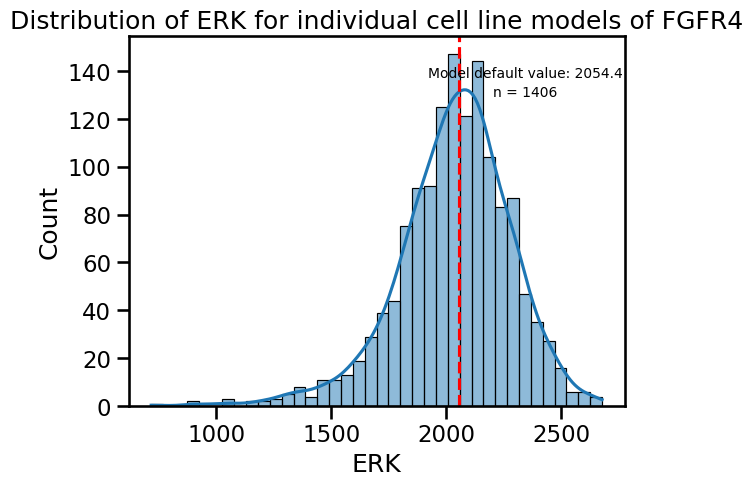

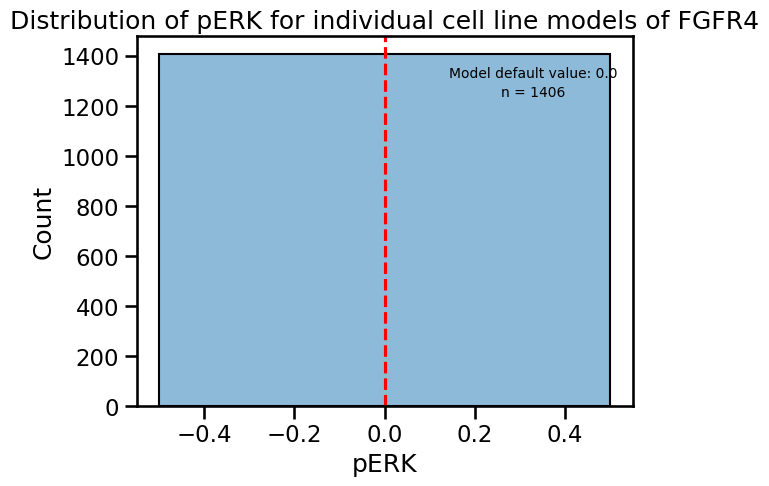

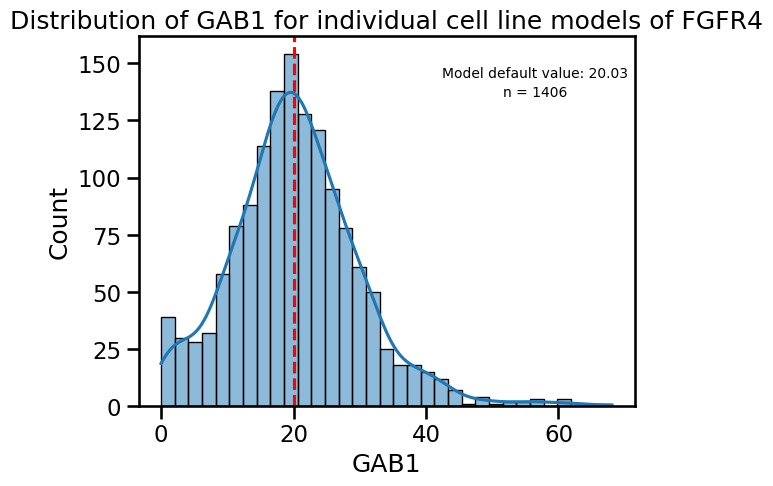

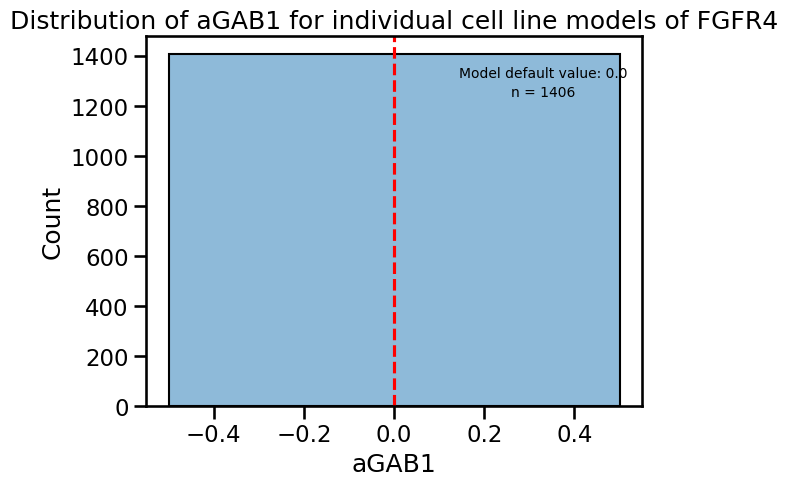

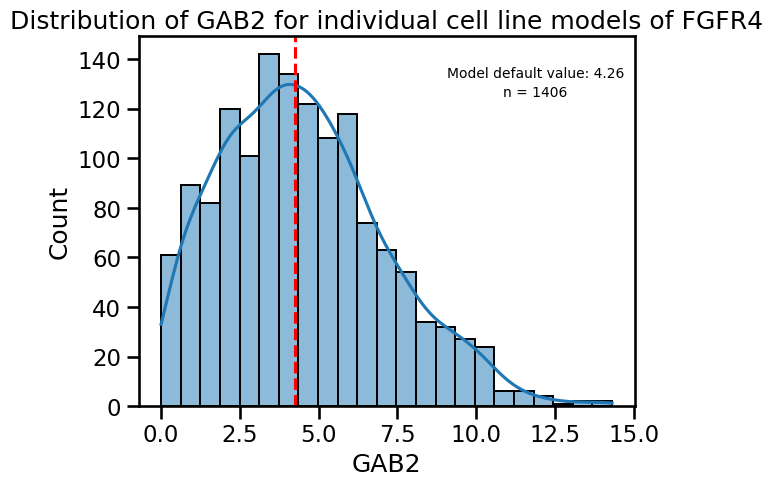

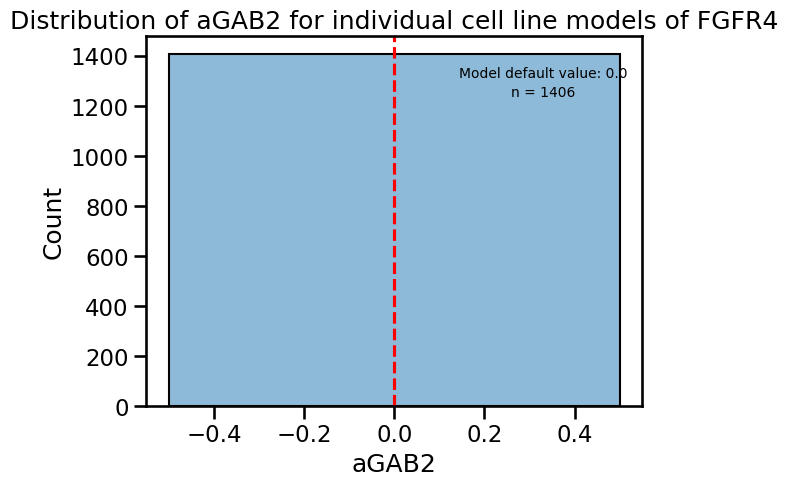

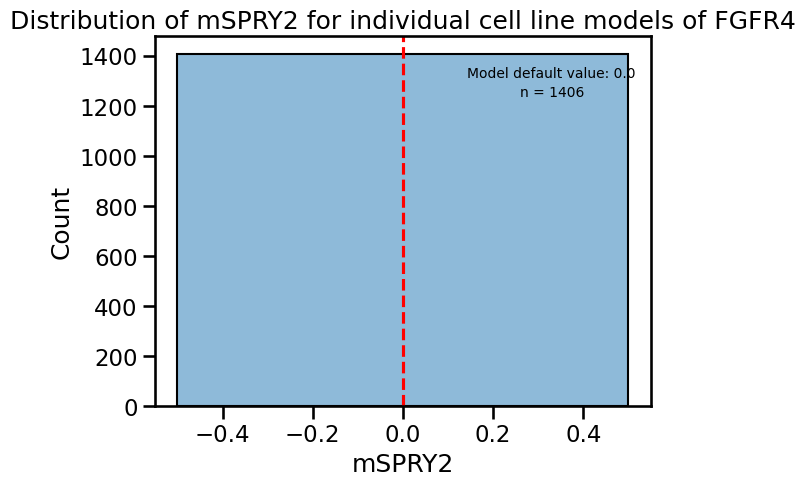

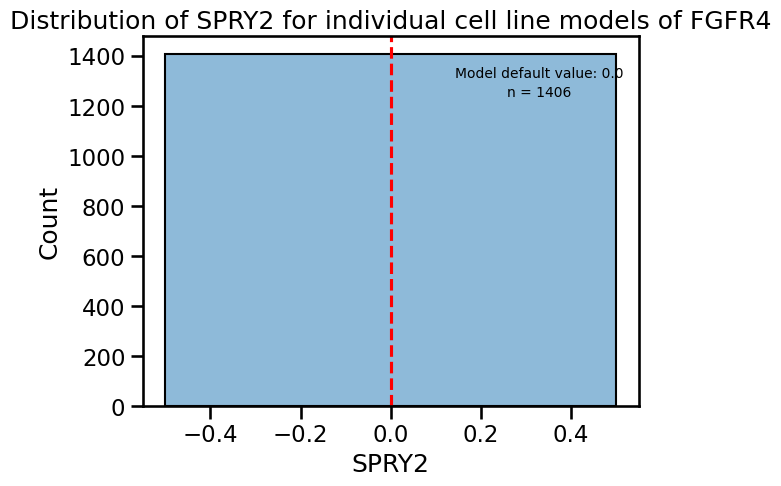

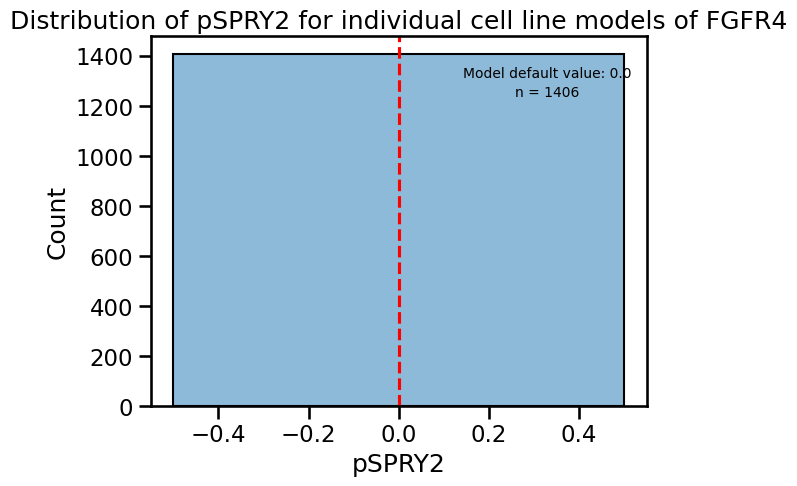

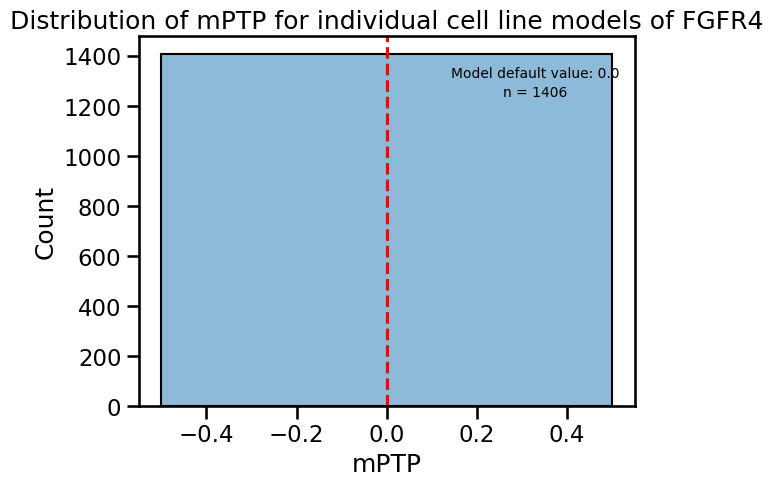

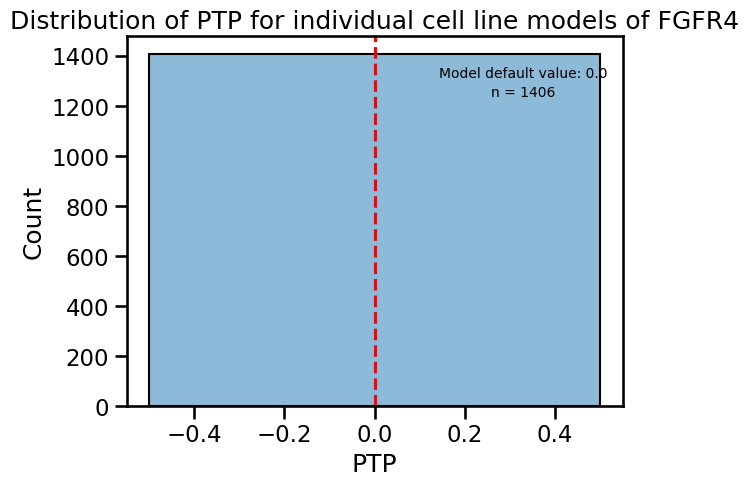

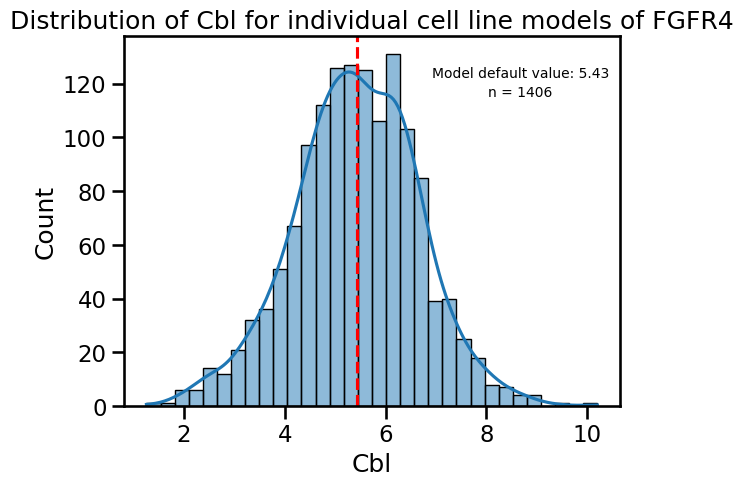

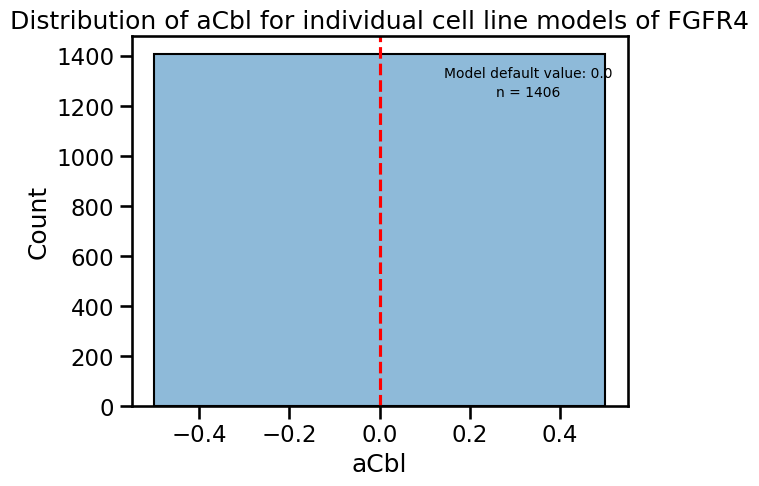

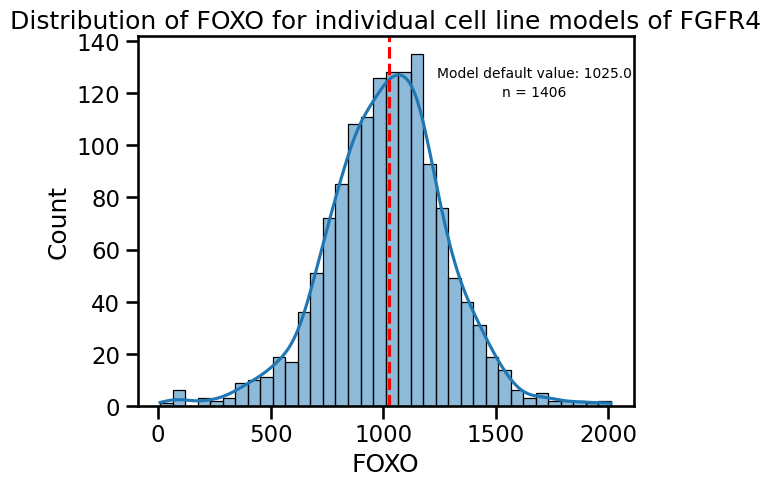

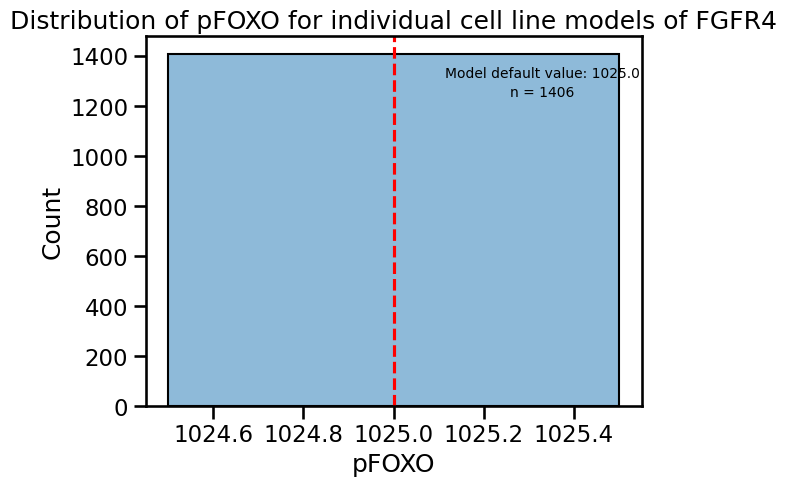

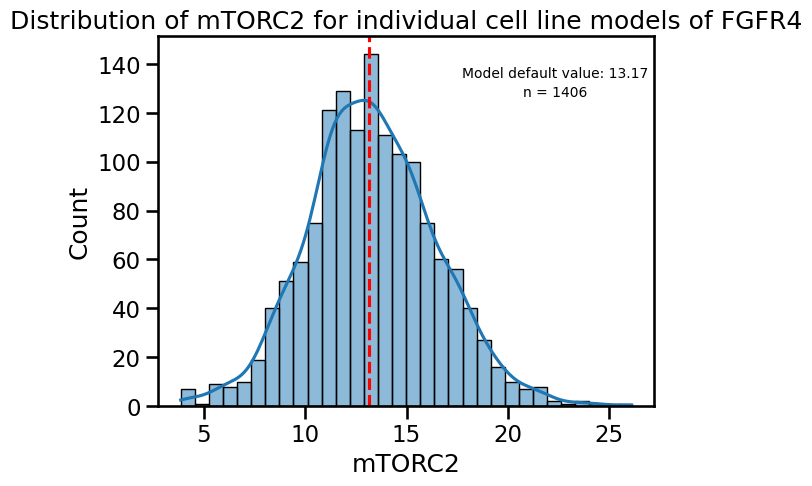

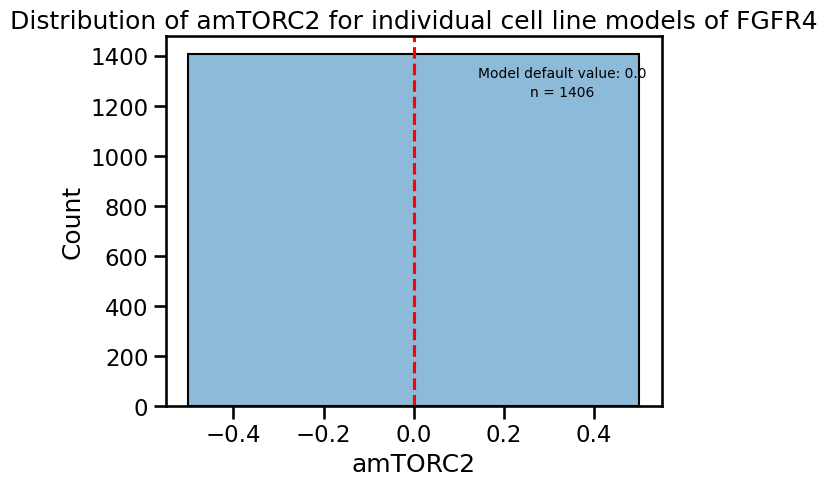

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the visualization as talk 
sns.set_context("talk")

# plot the distribution of each column in the initial conditions
n = initial_conditions.shape[0]
for col in initial_conditions.columns[1:]:
    sns.histplot(initial_conditions[col], kde=True)
    
    # add a vertical line for the model default value
    plt.axvline(match_rules_df.loc[match_rules_df['specie'] == col]['initial_value'].values[0], color='r', linestyle='--')
    
    plt.title(f'Distribution of {col} for individual cell line models of FGFR4')
    
    # add caption 
    plt.text(0.8, 0.9, f'Model default value: {match_rules_df.loc[match_rules_df["specie"] == col]["initial_value"].values[0]}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.8, 0.85, f'n = {n}',
             horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

    # plt.show()